# Product Recognition on Store Shelves
## Computer Vision and Image Processing - Exam Project
### Nicholas Antonio Carroll, nicholas.carroll@studio.unibo.it - Laura Mazzuca, laura.mazzuca@studio.unibo.it

## Step A: Multiple Product Detection


### Local Invariant Features Paradigm

Allows to successfully identify objects in scene from a 
single model image per object.

**Pros:**
* Quite effective for the detection of textured objects.
* Scale/rotation and illuminance invariance.
* Works under partial occlusion.
* Only one model image per object required.
* Fully implementable in openCV with few lines of code.

**Cons**:
* Suffers from changes in camera viewpoint.
* Can be slow when the number of objects to recognize increases
* Does not work well with deformable objects or to detect categories of objects.

**Four steps**:
1. **Detection**: Identify salient repeatable points (Keypoints) in model and scene images.
2. **Description**: Create a unique description of each point, usually based on its local pixel neighborhood.
3. **Matching**: Match point from scene and model according to a similarity function between the descriptors.
4. **Position Estimation**: Estimate the position of the object in the scene image given enough matching points 

In [533]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
scene_paths=['images/scenes/e1.png','images/scenes/e2.png','images/scenes/e3.png','images/scenes/e4.png','images/scenes/e5.png']
model_paths=['images/models/0.jpg','images/models/1.jpg','images/models/11.jpg','images/models/19.jpg','images/models/24.jpg','images/models/25.jpg','images/models/26.jpg']

Load the train images:

In [534]:
img_train = []
for p in scene_paths:
    img_train.append(cv2.imread(p, cv2.IMREAD_GRAYSCALE)) # trainImage

And all the query images:

In [535]:
img_query = []
for p in model_paths:
    img_query.append(cv2.imread(p, cv2.IMREAD_GRAYSCALE)) # queryImage


### 1. Keypoint Detection
Initialize the SIFT detector object in the following way:


In [536]:
# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

Then we need to find keypoints. We will use _detect_ method of the SIFT detector object. Let us find the keypoints of all the query images:

In [537]:
# find the keypoints and descriptors with SIFT
kp_query = []
for img in img_query:
    kp_query.append(sift.detect(img))

Now, let us find and draw the keypoints for the train images:

In [538]:
kp_train = []
for img in img_train:
    kp_train.append(sift.detect(img))

### 2. Keypoints Description 

Compute for each keypoint a unique description usually based on the nearby pixels (descriptor support).

A good keypoint descriptor should be:
* Repeatable: the descriptions computed at homologus points should be as similar as possible.
* Distinctive: capture the salient informations around the keypoint despite various nuisances (e.g. light changes). 
* Compact: minimize memory occupancy to allow efficient matching.
* Fast: it is usually applied to hundred or thousand of keypoints in each image.

**Given the patch surrounding a keypoint, can we use raw pixel intensities as descriptor?**

Different algorithms provides different descriptions, the common idea is to describe keypoints using an array (histogram) of values that encodes the appearance of its local neighborhood. The size of the support depends on the scale associated to the keypoint (i.e. scale invariance). 
The descriptor are computed according to the orientation associated to the  keypoint (i.e rotation invariance).

The histogram used for the description could be made of:
* floats: more distinctive, high memory footprint 
* bits: less distinctive, small memory footprint (binary descriptors)

Some well known algorithms:
1. **SIFT**: 128 floats array (4.096 bytes for each descriptor)
2. **SURF**: 64 floats array (2.048 bytes for each descriptor)
3. **BRISK**:  512 bit array (64 bytes for each descriptor)
4. **ORB**: 256 bit array (32 bytes for each descriptor)

We will use the SIFT descriptor for this sample study. We can use the same SIFT detector object calling the *compute* method:

In [539]:
# Describing keypoints for query and train images
des_query = np.empty(len(img_query), dtype=object)
des_train = np.empty(len(img_train), dtype=object)

for i in range(len(img_query)):
    kp_query[i], des_query[i] = sift.compute(img_query[i], kp_query[i])
for i in range(len(img_train)):
    kp_train[i], des_train[i] = sift.compute(img_train[i], kp_train[i])

### 3. Feature Matching

Descriptors extracted from the scene are compared with those extracted from the models to find couples of similar ones. Classic Nearest Neighbour(NN) Search problem: Given a set of points $n$ points $R=\{r_0,...,r_n\}$, a query point $q$ and a distance function $D$; find the point $r_{nn} \in R$ such that:

$D(q,r_{nn})<D(q,r_k), \forall r_k \in R$

In our scenario points are feature vectors and the distance function is Euclidean distance for floats or 
Hamming distance for bits. 

Naive idea - Brute force matcher: 
For each keypoint $q$ detected in scene compute all the $D(q,r_{nn})$ to find the minimum. Too slow to be applied in a lot of application, may sometimes be used with binary descriptor (distance function is a simple XOR between the descriptors). 

Smart idea - indexing technique:
Use efficient indexing such as KD-tree techniques borrowed from database management to speed up the search.
* Kd-tree - exact
* BBF - approximated
* LSH - for binary descriptor

**Approximate techniques** help speeding up the search.

For instance, we will use an approximate kd-tree algorithm from **FLANN** (Fast Library for Approximate Nearest Neighbors) included in OpenCV. 

**FLANN** contains a collection of algorithms optimized for fast nearest neighbor search in large datasets and for high dimensional features.

To implement it in **OpenCV** we can do the following.

In [540]:
# Defining index for approximate kdtree algorithm
FLANN_INDEX_KDTREE = 1

# Defining parameters for algorithm 
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

# Defining search params.
# checks=50 specifies the number of times the trees in the index should be recursively traversed.
# Higher values gives better precision, but also takes more time
search_params = dict(checks = 500)

# Initializing matcher
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Matching and finding the 2 closest elements for each query descriptor.
matches_per_image = np.empty(len(img_train), dtype=object)
i = 0 #index for the train images

for des_t in des_train: #for each scene
    matches_per_image[i] = [] #create a list that will hold the matches wrt each model image
    for des_q in des_query: #for each query image
        matches_per_image[i].append(flann.knnMatch(des_q,des_t,k=2)) #compute the matches
    i = i+1

In [541]:
good = np.empty(len(img_train), dtype=object)
i=0
j=0
for mat_img in matches_per_image:#for each list of matches related to an image wrt a train image
    good[i] = np.empty(len(img_query), dtype=object)
    j=0
    for matches in mat_img: # for each list of matches related to the train image j
        good[i][j] = []
        for m,n in matches:
            if m.distance < 0.7*n.distance:
                good[i][j].append(m)
        j=j+1
    i=i+1

In [542]:
img_train_rgb = []
for p in scene_paths:
    img_train_rgb.append(cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)) # trainImage

### 4. Position Estimation
We can use  **Random Sample Consensus (RANSAC)**, an algorithm to fit a parametric model to noisy data. In our case estimate an homography from good matches while identifying and discarding the wrong ones.

### RANSAC algorithm:
Given a set of observation $O=\{o_1...o_n\}$ and a certain parametric model $M$, repeat iteratively:
1. Pick a random (small) subset $I$ of $O$ called inlier set.
2. Fit a model $M_i$ according to the observations in $I$.
3. Test all the other observations against $M_i$, add to a new set $C$ (consensus set) all the observations that fit $M_i$ according to a model specific loss function.
4. If the consensus set is bigger than the one associated with the current best model $M_b$, proceed to step 5, other way return to step 1.
5. Re-compute $M_i$ according to the observations in $I \cup C$, then set $M_b=M_i$. Restart from step 1. 

The procedure is repeated for a fixed amount of steps, at the end the best model is returned.

A simple example of RANSAC result used to fit a line to a set of 2D point with Euclidean distance as loss function:
In our case we use the homography as parametric model and the reprojection error as loss function.

If we compute a bounding box transforming the corner of the model image in the scene image reference system with an Homography computed using RANSAC we obtain the following result:


In [543]:
# Checking if we found enough matching
MIN_MATCH_COUNT = 50
color = (0, 255, 0)
for i in range(len(img_train)):
    cur_kp_train = kp_train[i]
    for j in range(len(img_query)):
        if len(good[i][j])>MIN_MATCH_COUNT:
            cur_kp_query = kp_query[j]
            # building the corrspondences arrays of good matches
            src_pts = np.float32([ cur_kp_query[m.queryIdx].pt for m in good[i][j] ]).reshape(-1,1,2)
            dst_pts = np.float32([ cur_kp_train[m.trainIdx].pt for m in good[i][j] ]).reshape(-1,1,2)
            # Using RANSAC to estimate a robust homography. 
            # It returns the homography M and a mask for the discarded points
            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

            # Mask of discarded point used in visualization
            matchesMask = mask.ravel().tolist()
            # Corners of the query image
            h,w = img_query[j].shape
            pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

            # Projecting the corners into the train image
            dst = cv2.perspectiveTransform(pts,M)

            # Drawing the bounding box
            img_train_rgb[i] = cv2.polylines(img_train_rgb[i],[np.int32(dst)],True,color,3, cv2.LINE_AA)
        else:
            print( "Not enough matches are found - {}/{}".format(len(good[i][j]), MIN_MATCH_COUNT) )
            matchesMask = None

Not enough matches are found - 10/50
Not enough matches are found - 35/50
Not enough matches are found - 40/50
Not enough matches are found - 7/50
Not enough matches are found - 4/50
Not enough matches are found - 5/50
Not enough matches are found - 25/50
Not enough matches are found - 5/50
Not enough matches are found - 17/50
Not enough matches are found - 43/50
Not enough matches are found - 10/50
Not enough matches are found - 8/50
Not enough matches are found - 6/50


Finally, if we want to draw the matches we can do it in the following way:

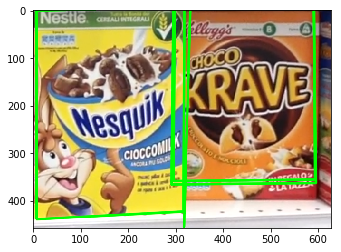

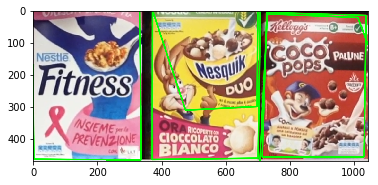

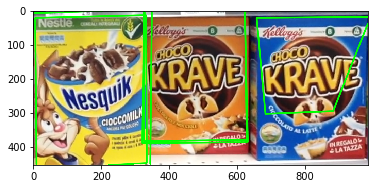

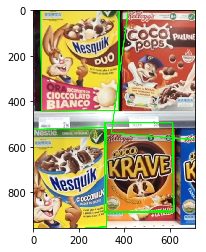

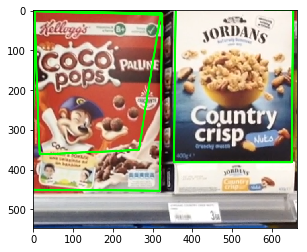

In [544]:
for img in img_train_rgb:
    plt.imshow(img)
    plt.show()

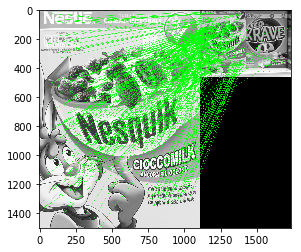

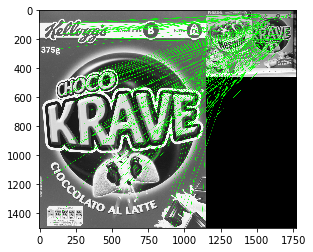

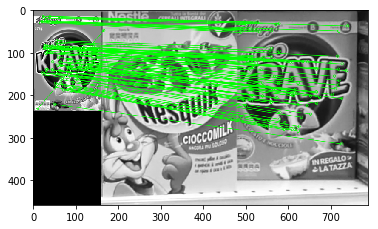

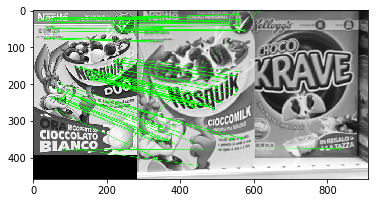

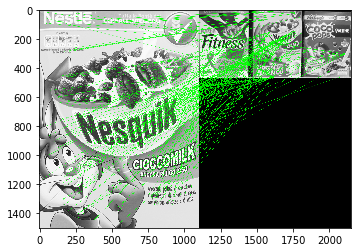

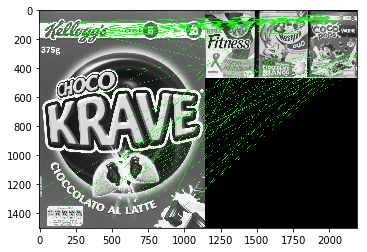

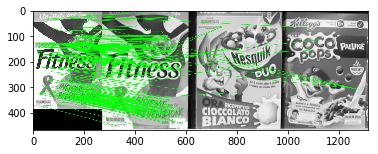

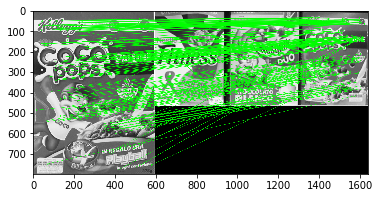

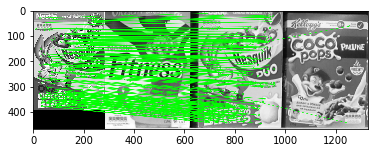

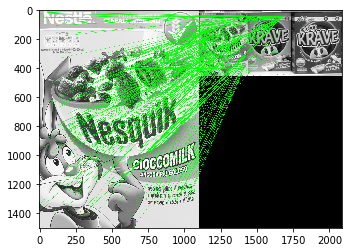

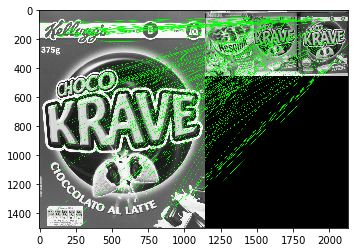

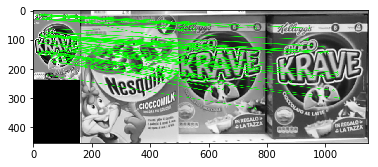

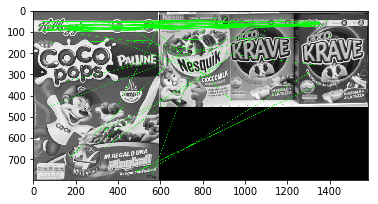

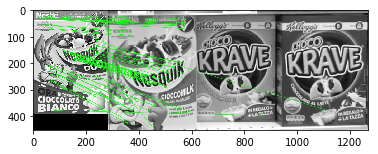

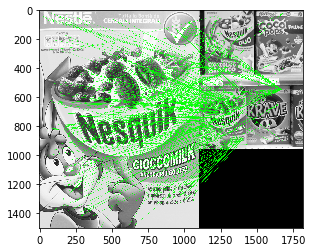

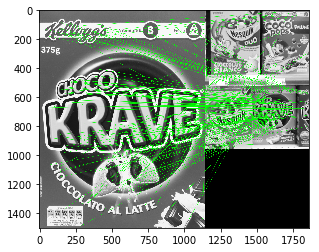

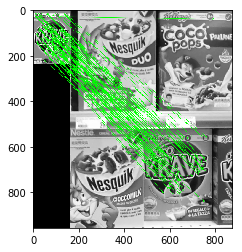

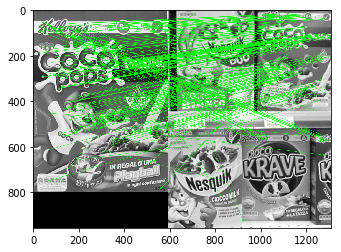

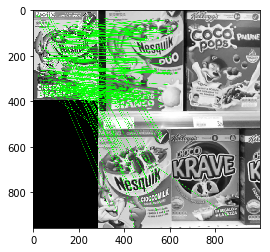

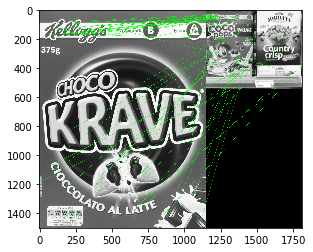

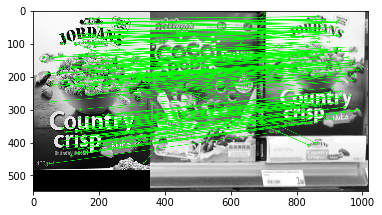

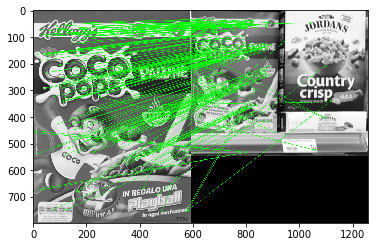

In [545]:
# Drawing the matches

draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None, # not draw keypoints only matching lines
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2) # not draw keypoints only lines
for i in range(len(img_train)):
    for j in range(len(img_query)):
        if len(good[i][j])>MIN_MATCH_COUNT:
            img3 = cv2.drawMatches(img_query[j],kp_query[j],img_train[i],kp_train[i],good[i][j],None,**draw_params)
            plt.imshow(img3, 'gray')
            plt.show()